# Performance analysis on synthetic data generators

This notebooks applies multiple synthetic data generator to simulate the real data set, Complete Journey. We provide step-by-step instructions on how to use each generator and analyze their performance from perspectives of Fidelity, Utility, and Privacy.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import logging

from syncomp.metrics.fidelity import (
    gather_fidelity_info_from_df,
    compare_fidelity_info
)
from syncomp.metrics.utility import (
    get_regression_training_data,
    get_classification_training_data,
    train_eval_model
)
from syncomp.utils.data_util import compute_unit_price
from syncomp.utils.viz_util import plot_heatmap, plot_hist
from syncomp.utils.holdout_util import split_dataframe
from syncomp.utils.train_util import train_autodiff

logging.getLogger().setLevel(logging.INFO)

%reload_ext autoreload
%autoreload 2

## Real Data Exploration

> The Complete Journey dataset characterizes household level transactions over one year from a group of 2,469 households who are frequent shoppers at a grocery store. It contains all of each household’s purchases, not just those from a limited number of categories. For certain households, demographic information as well as direct marketing contact history are captured.

For a deep dive into the dataset exploration and data cleaning, please refer to notebook [Complete Journey Data Exploration](https://github.com/RetailMarketingAI/retailsynth/blob/main/analysis_workflow/1_complete_journey_eda/1_preprocess_analysis.ipynb).

In [51]:
# TODO: Show distributions of some key categorical variables and numerical variables we're gonna use to evaluate the model.

In [47]:
# read real df and synthetic df
real_df = pd.read_csv('../results/complete_dataset_filtered.csv', converters={'household_size': str})
# train_df, holdout_df, eval_df = split_dataframe(real_df, [0.4, 0.4, 0.2])

/var/folders/4_/hbrj9kqj3sn9lwnrjfqfn95rj_1g25/T/ipykernel_8683/1766604482.py:2: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  real_df = pd.read_csv('../results/complete_dataset_filtered.csv', converters={'household_size': str})


In [41]:
str_columns = real_df.select_dtypes(include=['object']).columns
real_df[str_columns] = real_df[str_columns].astype(str)

In [48]:
real_df.household_size.unique()

array(['2', '4', '1', '3', '5+'], dtype=object)

In [45]:
real_df.to_csv('../results/complete_dataset_filtered.csv', index=False)

## Models
1. StaSy
2. TabDDPM
3. AutoGAN
4. StaSy-AutoDiff
5. Med-AutoDiff
6. Tab-AutoDiff
7. CTGAN: https://github.com/sdv-dev/CTGAN
8. CTAB-GAN: https://github.com/Team-TUD/CTAB-GAN
7. RetailSynth[Optional]: Notice that RetailSynth focuses on imitating the transaction only, that it does not necessarily synthesize the categorical features, like customer demographics.

In [3]:
# TODO: need to finalize the list of models with Chi-Hua
# TODO: add shell command to run training jobs

In [22]:
# generate one syn_df using autodiff
# syn_df, time_duration = train_autodiff(train_df=train_df)
syn_df = pd.read_csv('../results/AutoDiff/1/synthetic_data.csv').iloc[:, 1:]

## Metrics

### Fidelity
1. Wasserstein distance of probability distributions for the following numerical features:
    - Store visit probability
    - Product purchase probability
    - Product demand
    - Basket size
    - Time between purchase
    - Price elasticity
2. Jensen Shannon divergence of distributions for the following categorical features:
    - Customer demographics (age, household size, etc.)
    - Store information (state, city, etc.)
3. Pearson Correlation between listed numerical features
4. Theil's U for listed categorical features
5. Correlation Ratio between listed categorical and numerical features
6. Business insights
    - Customer segmentation
    - Customer retention
    - Category penetration

In [4]:
# read synthetic df
categorical_columns = real_df.select_dtypes(include=['object']).columns
syn_df[categorical_columns] = syn_df[categorical_columns].astype(str)

In [5]:
sample_size = 1000
train_fidelity_info = gather_fidelity_info_from_df(train_df, sample_size=sample_size, exclude_columns=['household_id', 'basket_id'])
syn_fidelity_info = gather_fidelity_info_from_df(syn_df, sample_size=sample_size, exclude_columns=['household_id', 'basket_id'])
holdout_fidelity_info = gather_fidelity_info_from_df(holdout_df, sample_size=sample_size, exclude_columns=['household_id', 'basket_id'])

/Users/64313/Documents/repos/syncomp/syncomp/metrics/corr.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mean_values, inplace=True)
/Users/64313/Documents/repos/syncomp/syncomp/metrics/corr.py:77: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when 

(0.0, 30.0)

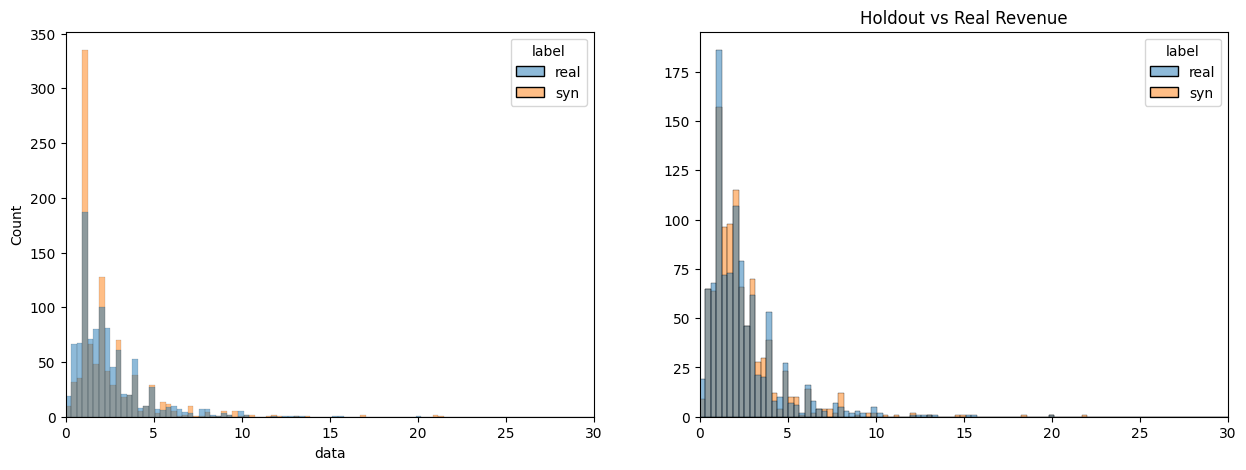

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_hist(train_fidelity_info[0]["revenue"], syn_fidelity_info[0]["revenue"], ax=ax1, title="Synthetic vs Real Revenue")
ax1.set_xlim(0, 30)
plot_hist(train_fidelity_info[0]["revenue"], holdout_fidelity_info[0]["revenue"], ax=ax2, title="Holdout vs Real Revenue")
ax2.set_xlim(0, 30)

(0.0, 30.0)

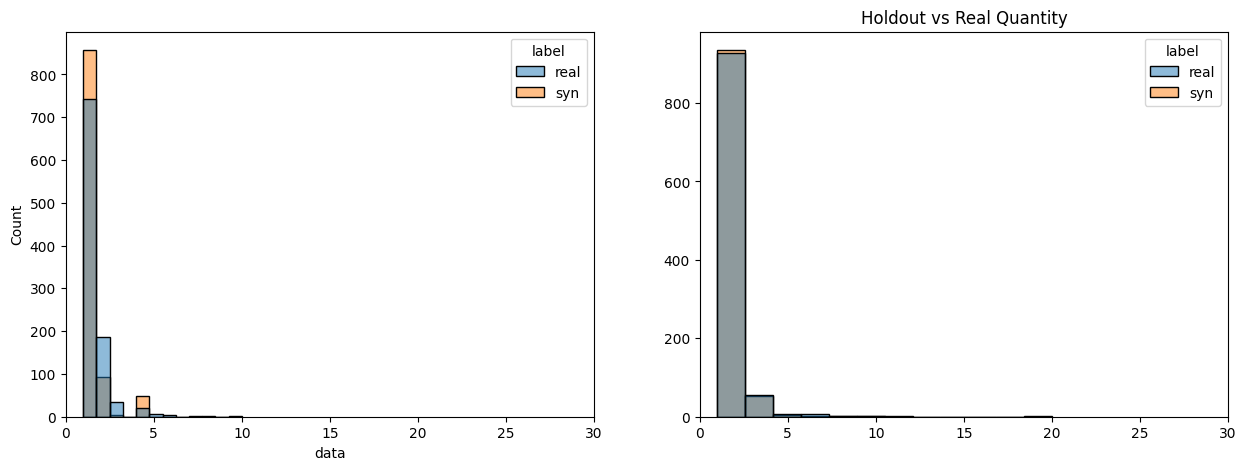

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_hist(train_fidelity_info[0]["quantity"], syn_fidelity_info[0]["quantity"], ax=ax1, title="Synthetic vs Real Quantity")
ax1.set_xlim(0, 30)
plot_hist(train_fidelity_info[0]["quantity"], holdout_fidelity_info[0]["quantity"], ax=ax2, title="Holdout vs Real Quantity")
ax2.set_xlim(0, 30)

In [8]:
fidelity_metrics = compare_fidelity_info(train_fidelity_info, syn_fidelity_info)
fidelity_metrics_holdout = compare_fidelity_info(train_fidelity_info, holdout_fidelity_info)

In [9]:
# show the wasserstein distance between numerical features from the real and synthetic data
fidelity_metrics[0]

{'visit_prob_per_store': 0.04013155415114118,
 'purchase_prob_per_product': 0.5546065198887962,
 'basket_size_per_product': 7603.13191137672,
 'time_between_purchase_per_customer': 9.66102765369502,
 'customer_retention_per_store': 0.06498462777398567,
 'category_penetration_per_category': 0.048125805604461266,
 'unit_price': 0.18425904400438728,
 'base_price': 0.16120876687294494,
 'revenue': 0.45034628677904637,
 'quantity': 0.18599999999999994}

In [10]:
# show the jensenshannon distance between categorical features from the real and synthetic data
fidelity_metrics[1]

{'age': 0.4048643903342486,
 'income': 0.24110776335137185,
 'household_size': 0.5810189255823662,
 'kids_count': 0.21221795891908296,
 'product_category': 0.3171832519234816,
 'department': 0.2768941909873031}

In [11]:
# show the euclideand distance between the correlation matrix of the real and synthetic data
fidelity_metrics[2]

{'pearson_coef': 2.2765910608389572,
 'theils_u': 4.671853821117221,
 'correl_ratio': 1.828042799370443}

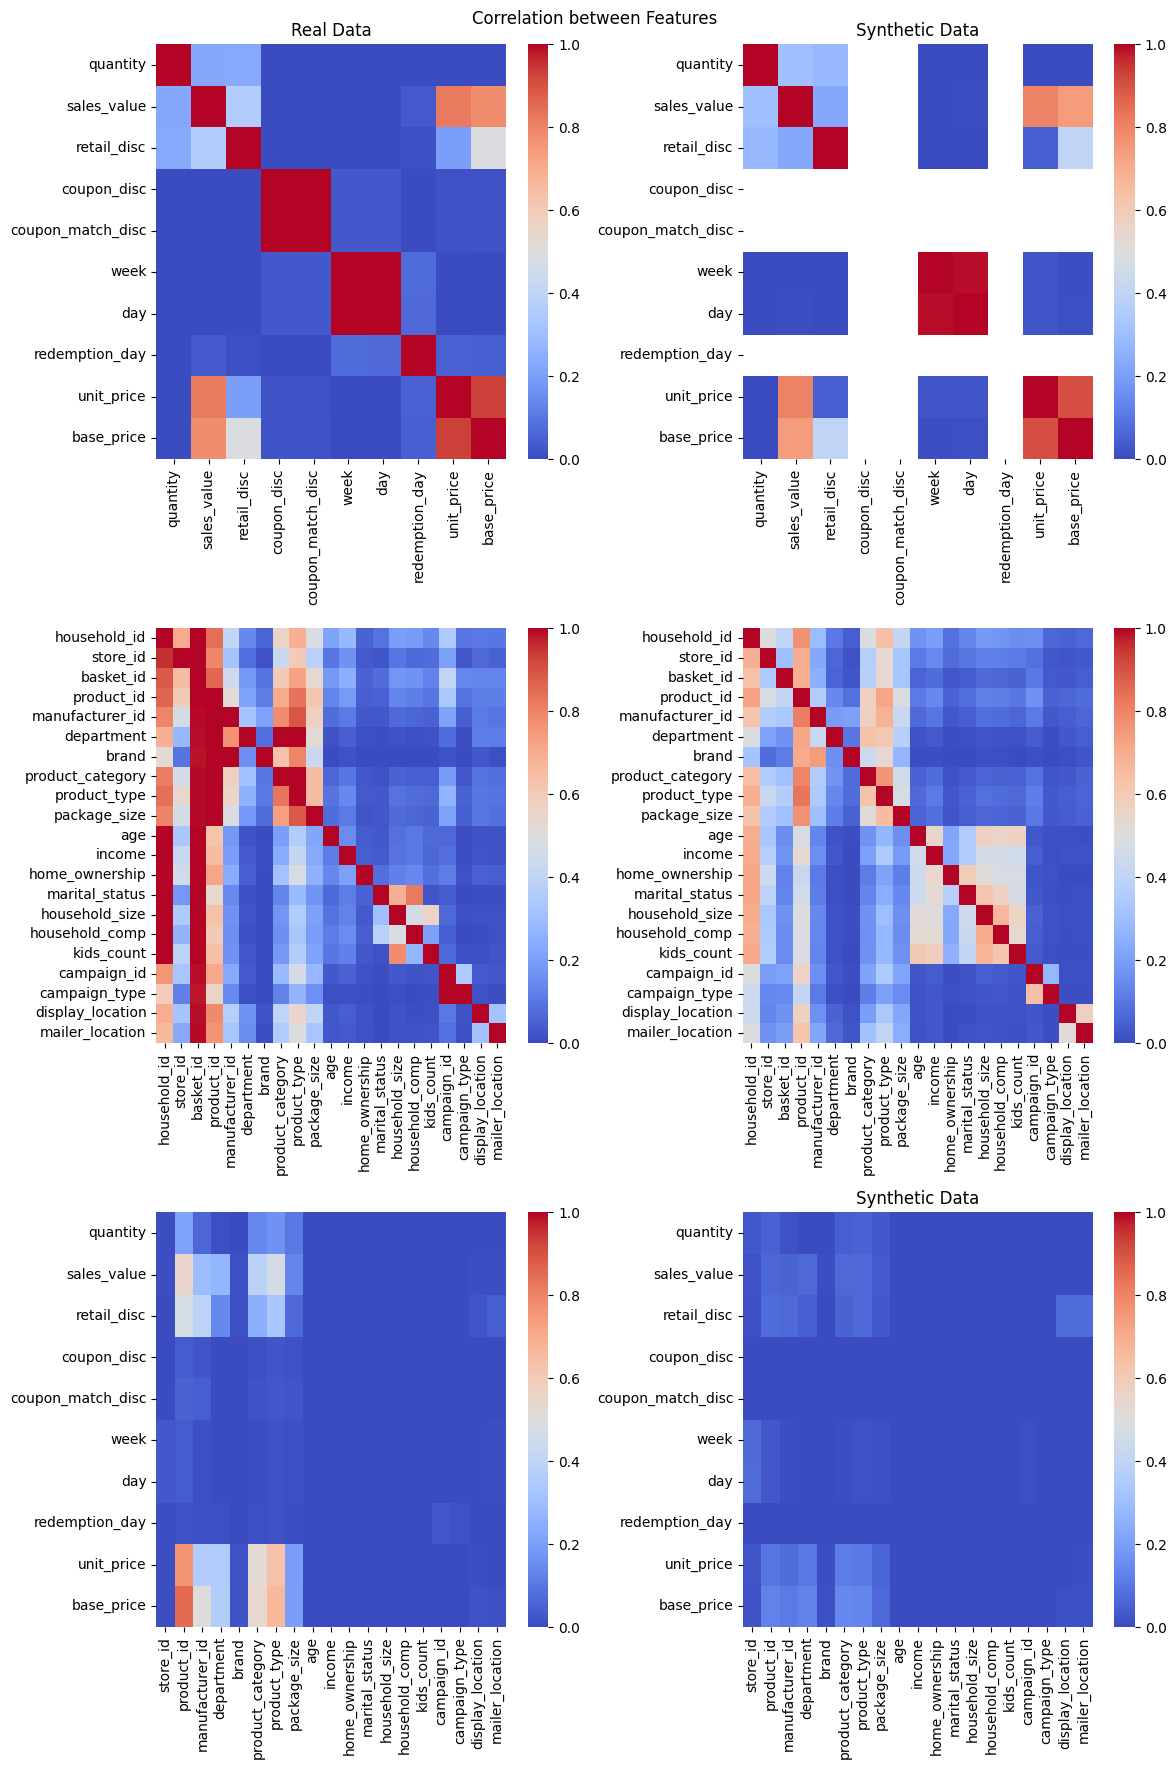

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(12, 18))
ax1, ax2 = axes[0]
plot_heatmap(train_fidelity_info[2]['pearson_coef'], ax=ax1, title='Real Data', vmin=0, vmax=1)
plot_heatmap(syn_fidelity_info[2]['pearson_coef'], ax=ax2, title='Synthetic Data', vmin=0, vmax=1)
ax1.set_title('Real Data')
ax2.set_title('Synthetic Data')
ax1, ax2 = axes[1]
plot_heatmap(train_fidelity_info[2]['theils_u'], ax=ax1, title='Real Data', vmin=0, vmax=1)
plot_heatmap(syn_fidelity_info[2]['theils_u'], ax=ax2, title='Synthetic Data', vmin=0, vmax=1)
ax1, ax2 = axes[2]
plot_heatmap(train_fidelity_info[2]['correl_ratio'], ax=ax1, title='Real Data', vmin=0, vmax=1)
plot_heatmap(syn_fidelity_info[2]['correl_ratio'], ax=ax2, title='Synthetic Data', vmin=0, vmax=1)

plt.suptitle('Correlation between Features')
plt.tight_layout()

In [13]:
fidelity_metrics_holdout[0]

{'visit_prob_per_store': 0.0009746624154662147,
 'purchase_prob_per_product': 7.860521001312737e-05,
 'basket_size_per_product': 0.7020000000000001,
 'time_between_purchase_per_customer': 0.4906682248835079,
 'customer_retention_per_store': 0.009130027177008136,
 'category_penetration_per_category': 0.003656230585495862,
 'unit_price': 0.07346308982683981,
 'base_price': 0.11228416666666668,
 'revenue': 0.13428,
 'quantity': 0.05900000000000005}

In [14]:
fidelity_metrics_holdout[1]

{'age': 0.409319041638804,
 'income': 0.29214803866271116,
 'household_size': 0.6596296429537436,
 'kids_count': 0.2592835096803409,
 'product_category': 0.33265501677336984,
 'department': 0.31820008424375124}

In [15]:
fidelity_metrics[1]

{'age': 0.4048643903342486,
 'income': 0.24110776335137185,
 'household_size': 0.5810189255823662,
 'kids_count': 0.21221795891908296,
 'product_category': 0.3171832519234816,
 'department': 0.2768941909873031}

In [16]:
fidelity_metrics_holdout[2]

{'pearson_coef': 0.9935844262939723,
 'theils_u': 0.30195352296636147,
 'correl_ratio': 0.06454684340547744}

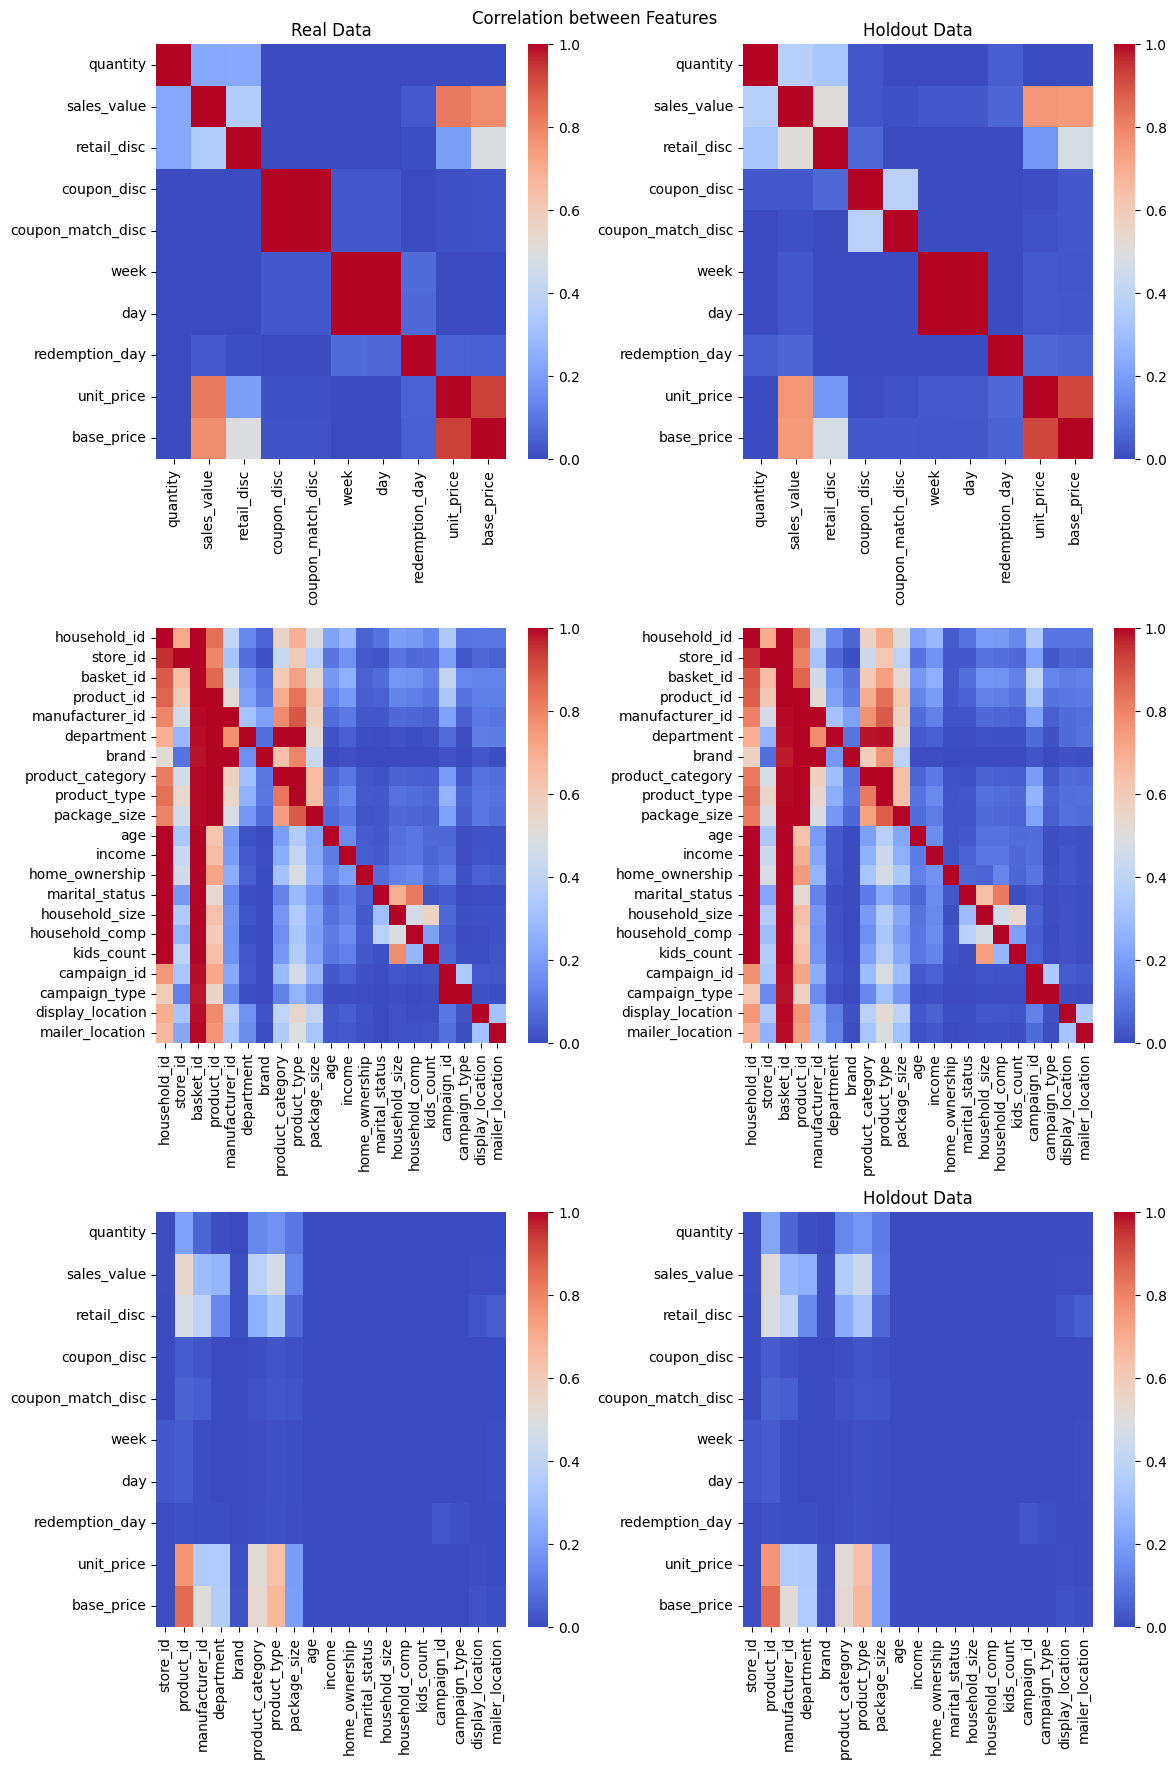

In [17]:
fig, axes = plt.subplots(3, 2, figsize=(12, 18))
ax1, ax2 = axes[0]
plot_heatmap(train_fidelity_info[2]['pearson_coef'], ax=ax1, title='Real Data', vmin=0, vmax=1)
plot_heatmap(holdout_fidelity_info[2]['pearson_coef'], ax=ax2, title='Holdout Data', vmin=0, vmax=1)
ax1.set_title('Real Data')
ax2.set_title('Holdout Data')
ax1, ax2 = axes[1]
plot_heatmap(train_fidelity_info[2]['theils_u'], ax=ax1, title='Real Data', vmin=0, vmax=1)
plot_heatmap(holdout_fidelity_info[2]['theils_u'], ax=ax2, title='Holdout Data', vmin=0, vmax=1)
ax1, ax2 = axes[2]
plot_heatmap(train_fidelity_info[2]['correl_ratio'], ax=ax1, title='Real Data', vmin=0, vmax=1)
plot_heatmap(holdout_fidelity_info[2]['correl_ratio'], ax=ax2, title='Holdout Data', vmin=0, vmax=1)

plt.suptitle('Correlation between Features')
plt.tight_layout()

### Utility
We define a classification task and a regression task to justify if statistical ML models can learn the patterns from the synthetic data. Classification task is to predict whether the customer will make a purchase at one time step. Regression task is to predict the total demand or revenue of a customer at one time step. 
1. Classification task
    - Accuracy
    - F1 score
    - ROC AUC
    - Precision-Recall

In [3]:
train_df = compute_unit_price(train_df)
# syn_df = compute_unit_price(syn_df)
holdout_df = compute_unit_price(holdout_df)
eval_df = compute_unit_price(eval_df)

INFO:root:Computing unit price
INFO:root:Computing unit price
INFO:root:Computing unit price


In [10]:
train_X, train_y = get_classification_training_data(train_df)
syn_X, syn_y = get_classification_training_data(syn_df)
holdout_X, holdout_y = get_classification_training_data(holdout_df)
eval_X, eval_y = get_classification_training_data(eval_df)
# train a random forest model
real_metric = train_eval_model(LogisticRegression, train_X, train_y, eval_X, eval_y, model_type='classification')
holdout_metric = train_eval_model(LogisticRegression, holdout_X, holdout_y, eval_X, eval_y, model_type='classification')
syn_metric = train_eval_model(LogisticRegression, syn_X, syn_y, eval_X, eval_y, model_type='classification')

INFO:root:Computing unit price
INFO:root:Computing unit price
INFO:root:Computing unit price
INFO:root:Computing unit price
/Users/64313/Documents/repos/syncomp/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
real_metric

{'accuracy': 0.6282690337999317,
 'f1': 0.3743247902539938,
 'roc': 0.5550992936152082,
 'precision': 0.3726971049319144,
 'recall': 0.375966755165647}

In [12]:
holdout_metric

{'accuracy': 0.6299419597132127,
 'f1': 0.36087033433575094,
 'roc': 0.5496921566603701,
 'precision': 0.36885245901639346,
 'recall': 0.3532263650005772}

In [13]:
syn_metric

{'accuracy': 0.704233526800956,
 'f1': 0.0,
 'roc': 0.5,
 'precision': 0.0,
 'recall': 0.0}

2. Regression task
    - Mean Squared Error
    - R2 score

In [32]:
train_X, train_y = get_regression_training_data(train_df)
syn_X, syn_y = get_regression_training_data(syn_df)
holdout_X, holdout_y = get_regression_training_data(holdout_df)
eval_X, eval_y = get_regression_training_data(eval_df)
# train a linear regression model
real_metric = train_eval_model(LinearRegression, train_X, train_y, eval_X, eval_y)
holdout_metric = train_eval_model(LinearRegression, holdout_X, holdout_y, eval_X, eval_y)
syn_metric = train_eval_model(LinearRegression, syn_X, syn_y, eval_X, eval_y)

INFO:root:Computing unit price
INFO:root:Computing unit price
INFO:root:Computing unit price
INFO:root:Computing unit price


In [ ]:
real_metric

{'mse': 6.746181517021324, 'r2': -2.288645810301879}

In [27]:
syn_metric

{'mse': 6.328864574508013, 'r2': -32.62702350278505}

In [28]:
holdout_metric

{'mse': 6.763136621012169, 'r2': -2.250101123961513}

We also define an unsupervised learning task to justify if clustering algorithms can learn the patterns from the synthetic data. The clustering task is to cluster the customers based on their purchase behavior.
1. Silhouette Score between synthetic cluster and real cluster

### Privacy
1. Distances to Closest Records
2. TAPAS: https://github.com/alan-turing-institute/tapas

In [74]:
from syncomp.metrics.privacy import distance_closest_record

In [78]:
distance_closest_record(train_df, holdout_df, 1000)

4.58257569495584

In [8]:
import sys
sys.path.append('../')
import tapas_local.datasets
import tapas_local.generators
import tapas_local.threat_models
import tapas_local.attacks
import tapas_local.report
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

In [96]:
# data = tapas_local.datasets.TabularDataset.read("../results/2011 Census Microdata Teaching File")
data = tapas_local.datasets.TabularDataset.read("../results/complete_dataset_filtered")

In [6]:
schema

[{'name': 'household_id', 'type': 'countable', 'representation': 'integer'},
 {'name': 'store_id', 'type': 'countable', 'representation': 'integer'},
 {'name': 'basket_id', 'type': 'countable', 'representation': 'integer'},
 {'name': 'product_id', 'type': 'countable', 'representation': 'integer'},
 {'name': 'quantity', 'type': 'countable', 'representation': 'integer'},
 {'name': 'sales_value',
  'type': 'real/non-negative',
  'representation': 'number'},
 {'name': 'retail_disc',
  'type': 'real/non-negative',
  'representation': 'number'},
 {'name': 'coupon_disc',
  'type': 'real/non-negative',
  'representation': 'number'},
 {'name': 'coupon_match_disc',
  'type': 'real/non-negative',
  'representation': 'number'},
 {'name': 'week', 'type': 'countable', 'representation': 'integer'},
 {'name': 'manufacturer_id',
  'type': 'real/non-negative',
  'representation': 'number'},
 {'name': 'department',
  'type': 'finite',
  'representation': ['PASTRY',
   'GROCERY',
   'PRODUCE',
   'DRUG GM

In [9]:
import tempfile
import json

with open("../results/complete_dataset_filtered.json") as f:
    schema = json.load(f)

with tempfile.TemporaryDirectory() as tmpdir:
    train_df.to_csv(f"{tmpdir}/complete_dataset.csv", index=False)
    with open(f"{tmpdir}/complete_dataset.json", 'w') as f:
        json.dump(schema, f)
    data = tapas_local.datasets.TabularDataset.read(f"{tmpdir}/complete_dataset")


In [31]:
class GeneratorReadFromLocal(tapas_local.generators.Generator):
    def __init__(self, model="AutoDiff", random_state=0, dir="results"):
        self.model = model
        self.random_state = random_state
        self.dir = dir
        super().__init__()

    def fit(self, dataset):
        self.dataset = dataset
        self.trained = True

    def generate(self, num_samples, **kwargs):
        # load synthetic data df and schema json
        syn_df = pd.read_csv(f"{self.dir}/{self.model}/{self.random_state}/synthetic_data.csv")
        with open(f"{self.dir}/complete_dataset_filtered.json") as f:
            schema = json.load(f)
        # construct TabularDataset object
        with tempfile.TemporaryDirectory() as tmpdir:
            syn_df.to_csv(f"{tmpdir}/complete_dataset.csv", index=False)
            with open(f"{tmpdir}/complete_dataset.json", 'w') as f:
                json.dump(schema, f)
            syn_data = tapas_local.datasets.TabularDataset.read(f"{tmpdir}/complete_dataset")
        
        return syn_data.sample(num_samples, random_state=self.random_state)
    
    def __call__(self, dataset, num_samples, **kwargs):
        self.fit(dataset)
        return self.generate(num_samples, random_state = self.random_state)


In [32]:
syn_generator = GeneratorReadFromLocal(model="AutoDiff", random_state=0, dir="../results")

In [33]:
generator = GeneratorReadFromLocal(model="AutoDiff", random_state=0, dir="../results")
data_knowledge = tapas_local.threat_models.AuxiliaryDataKnowledge(
      data,
      auxiliary_split=0.5,
      num_training_records=5
)
sdg_knowledge = tapas_local.threat_models.BlackBoxKnowledge(
    generator,
    num_synthetic_records=5,
)
threat_model = tapas_local.threat_models.TargetedMIA(
   attacker_knowledge_data=data_knowledge,
   target_record=data.get_records([0]),
   attacker_knowledge_generator=sdg_knowledge,
   generate_pairs=True,
   replace_target=True
)
attacker = tapas_local.attacks.GroundhogAttack()
attacker = tapas_local.attacks.ShadowModellingAttack(
   tapas_local.attacks.FeatureBasedSetClassifier(
      tapas_local.attacks.NaiveSetFeature() + tapas_local.attacks.HistSetFeature() + tapas_local.attacks.CorrSetFeature(),
      RandomForestClassifier(n_estimators = 2)
   ),
   label = "Groundhog"
)
attacker.train(threat_model, num_samples=1000)

/Users/64313/Documents/repos/syncomp/tapas_local/threat_models/mia.py:206: UserWarning: 1 target record(s) were found in the auxiliary data. This is not recommended: it is best to remove target records to avoid duplicates and ensure that the task of membership inference is meaningful.
  warnings.warn(


KeyboardInterrupt: 

In [100]:
attack_summary = threat_model.test(attacker, num_samples = 5)
metrics = attack_summary.get_metrics()
print("Results:\n", metrics.head())

/Users/64313/Documents/repos/syncomp/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/64313/Documents/repos/syncomp/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/64313/Documents/repos/syncomp/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/64313/Documents/repos/syncomp/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Results:
                                       dataset target_id generator     attack  \
0  ../results/complete_dataset_filtered (AUX)         0       Raw  Groundhog   

   accuracy  true_positive_rate  false_positive_rate  mia_advantage  \
0      0.61                0.22                  0.0           0.22   

   privacy_gain   auc  effective_epsilon  
0          0.78  0.61                inf  
